In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import env
import os
from matplotlib import style
from explore import *
from wrangle import *
from prepare import *
import math



from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Zillow Clustering Project

### Predicting Logerror of Zestimate

#### by Joshua Bryant

#### Sep 28, 2021

### Agenda
- Executive Summary
- Acquire Data
- Prep Data
- Split/Scale Data
- Exploration
- Hypothesis Testing
- Clustering
- Modeling

### Executive Summary
- I was not able to make use of clusters for my model
- My top features used ended up being: **bedroomcnt, buildingqualitytypeid, and longitude** based on a mix of features chosen by RFE and heatmap correlation
- My top model was LinearRegression (OLS)
    - Train and Validate beat the mean baseline
    - However, Test was slightly above
    - Could be because of overfitting due to my hyperparameters
- Conclusion: While my model was able to beat my baseline on Train and Validate, it was not able to beat it on test data
    - With more time: I would like to dig into clustering more and spend more time with different combinations
    - While my model ultimately did not beat the baseline in my test, I do think these features should be looked into more and with more time, could be engineered better to predict unseen data

### Acquire Data

In [2]:
df = wrangle_zillow()

In [3]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,county
0,14297519,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,...,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595,2017-01-01,None,Orange
1,17052889,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619,2017-01-01,None,Ventura
2,14186244,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383,2017-01-01,None,Orange
3,12177905,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01,Central,Los Angeles
4,10887214,3.0,3.0,8.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,6.037124e+07,...,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,0.006940,2017-01-01,Central,Los Angeles


In [4]:
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude',
       'lotsizesquarefeet', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'transactiondate',
       'heatingorsystemdesc', 'county'],
      dtype='object')

In [5]:
df.shape

(69523, 25)

### Prepare Data

In [6]:
# Checking for duplicates
df.duplicated().value_counts()

False    69523
dtype: int64

In [7]:
# Checking for nulls by columns
nulls_by_col(df)

,num_rows_missing,percent_rows_missing
parcelid,0,0.0
bathroomcnt,0,0.0
bedroomcnt,0,0.0
buildingqualitytypeid,0,0.0
calculatedfinishedsquarefeet,0,0.0
fips,0,0.0
latitude,0,0.0
longitude,0,0.0
lotsizesquarefeet,0,0.0
rawcensustractandblock,0,0.0


In [8]:
# Checking for nulls by rows
nulls_by_row(df)

,num_cols_missing,percent_cols_missing,index
0,0,0.0,69523


In [9]:
# Looking at column types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69523 entries, 0 to 77380
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      69523 non-null  int64  
 1   bathroomcnt                   69523 non-null  float64
 2   bedroomcnt                    69523 non-null  float64
 3   buildingqualitytypeid         69523 non-null  float64
 4   calculatedfinishedsquarefeet  69523 non-null  float64
 5   fips                          69523 non-null  float64
 6   latitude                      69523 non-null  float64
 7   longitude                     69523 non-null  float64
 8   lotsizesquarefeet             69523 non-null  float64
 9   rawcensustractandblock        69523 non-null  float64
 10  regionidcity                  69523 non-null  float64
 11  regionidcounty                69523 non-null  float64
 12  regionidzip                   69523 non-null  float64
 13  r

In [10]:
# For scientific notation

pd.set_option('display.float_format', lambda x: '%.5f' % x)

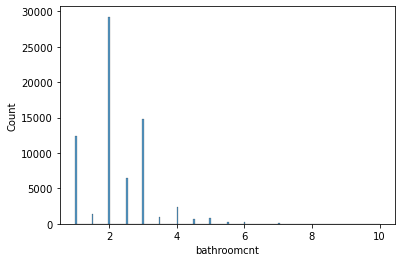

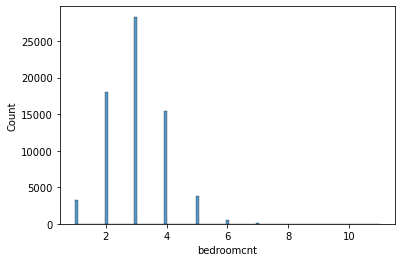

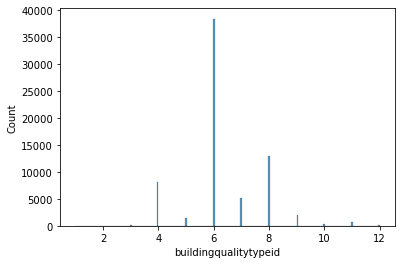

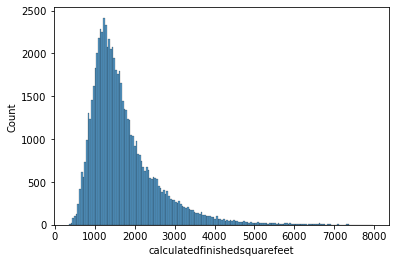

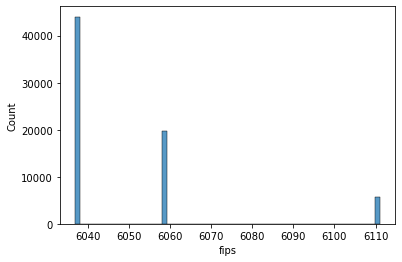

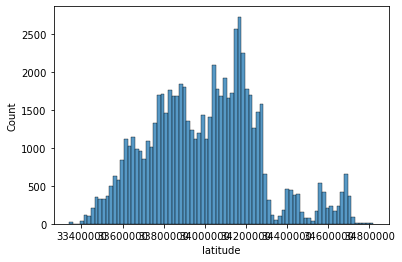

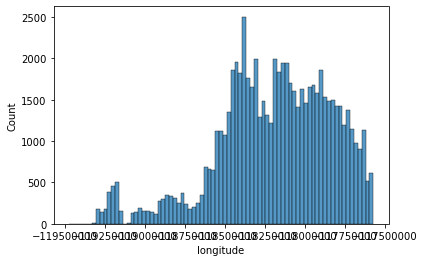

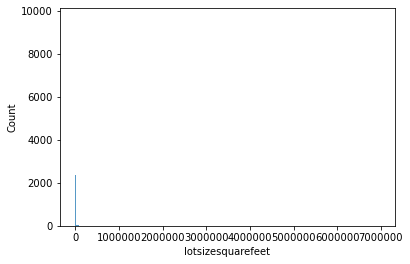

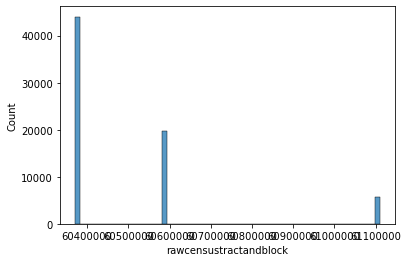

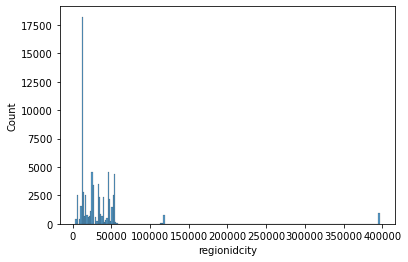

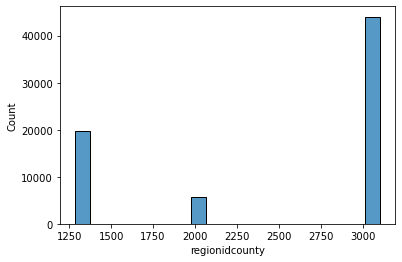

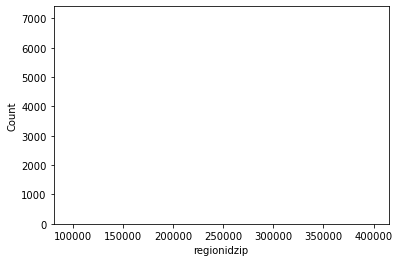

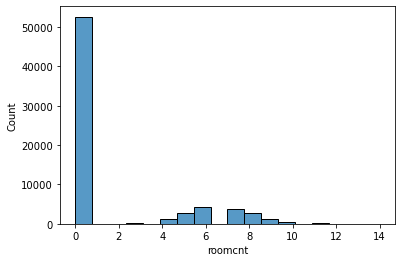

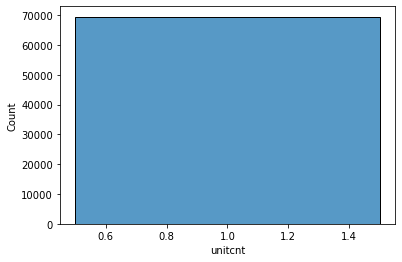

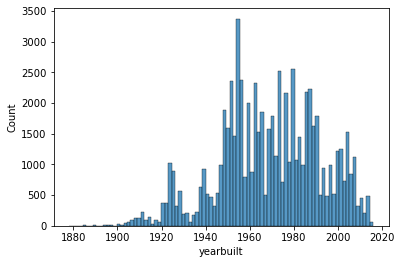

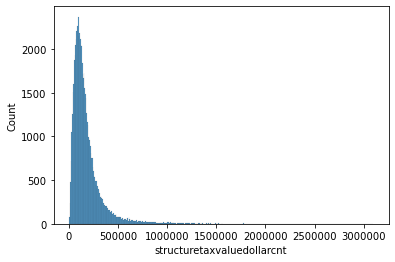

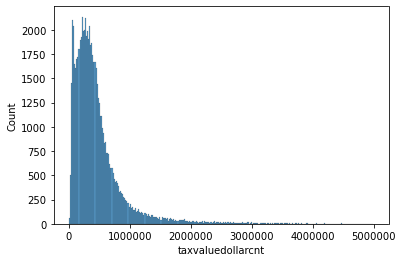

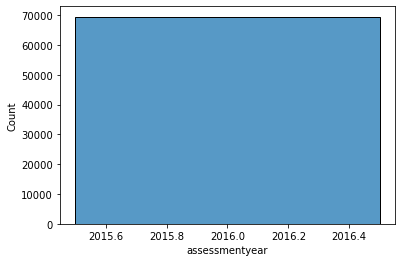

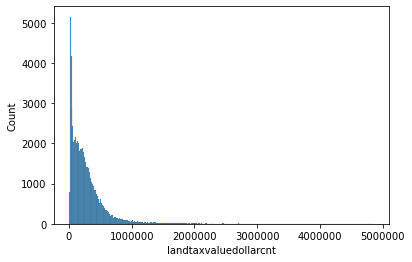

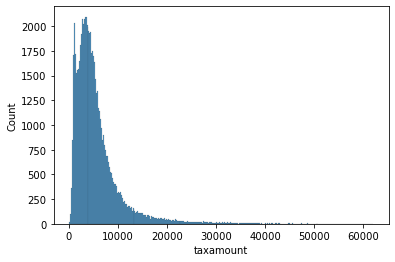

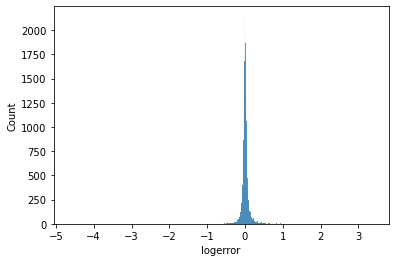

In [11]:
# Looking at distributions
for x in df.select_dtypes(include = 'float64'):
    sns.histplot(data = df[x])
    plt.ticklabel_format(useOffset=False, style = "plain")
    plt.show()

#### Takeaways:
- will need to drop outliers especially in bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, lotsizesquarefeet
- really only focused on any outliers that may have escaped the "single unit" filter in my SQL query
- however, I don't want any tax value outliers because perhaps it's on a premium location on the beach for example

In [12]:
# Creating lat and long values that can be used for visualization. The original values were multiplied by 10e6

df['actual_latitude'] = df.latitude*.000001
df['actual_longitude'] = df.longitude*.000001

df.drop(columns=['latitude','longitude'],inplace=True)

df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,county,actual_latitude,actual_longitude
0,14297519,3.50000,4.00000,6.00000,3100.00000,6059.00000,4506.00000,60590630.07201,53571.00000,1286.00000,...,1023282.00000,2016.00000,537569.00000,11013.72000,0.02559,2017-01-01,None,Orange,33.63493,-117.86921
1,17052889,1.00000,2.00000,6.00000,1465.00000,6111.00000,12647.00000,61110010.02301,13091.00000,2061.00000,...,464000.00000,2016.00000,376000.00000,5672.48000,0.05562,2017-01-01,None,Ventura,34.44927,-119.28153
2,14186244,2.00000,3.00000,6.00000,1243.00000,6059.00000,8432.00000,60590218.02201,21412.00000,1286.00000,...,564778.00000,2016.00000,479489.00000,6488.30000,0.00538,2017-01-01,None,Orange,33.88617,-117.82317
3,12177905,3.00000,4.00000,8.00000,2376.00000,6037.00000,13038.00000,60373001.00101,396551.00000,3101.00000,...,145143.00000,2016.00000,36225.00000,1777.51000,-0.10341,2017-01-01,Central,Los Angeles,34.24518,-118.24072
4,10887214,3.00000,3.00000,8.00000,1312.00000,6037.00000,278581.00000,60371236.01200,12447.00000,3101.00000,...,119407.00000,2016.00000,45726.00000,1533.89000,0.00694,2017-01-01,Central,Los Angeles,34.18512,-118.41464


In [13]:
df.landtaxvaluedollarcnt.describe()

count     69523.00000
mean     285024.33701
std      327302.64356
min         161.00000
25%       82371.00000
50%      203050.00000
75%      365958.00000
max     4847224.00000
Name: landtaxvaluedollarcnt, dtype: float64

In [14]:
# This house, for example is closer to the beach
df[df.landtaxvaluedollarcnt==4847224]

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,county,actual_latitude,actual_longitude
51430,13888322,4.00000,4.00000,6.00000,2570.00000,6059.00000,3728.00000,60590628.00204,53571.00000,1286.00000,...,4961367.00000,2016.00000,4847224.00000,52419.76000,0.03207,2017-06-28,None,Orange,33.60518,-117.91426


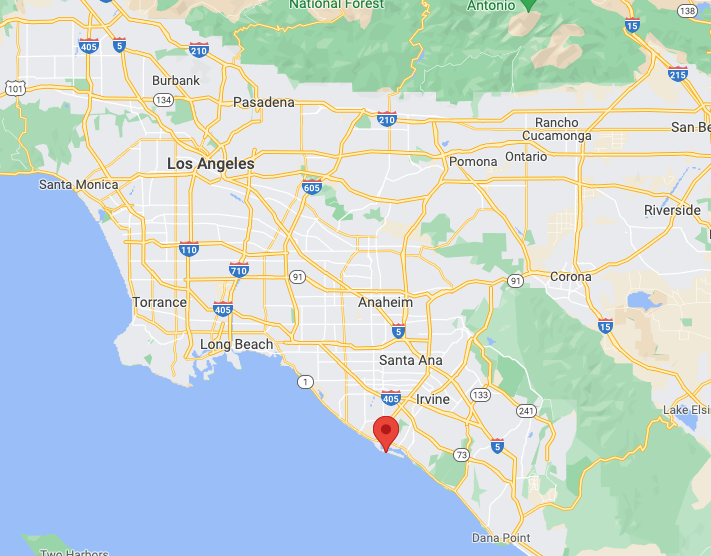

In [15]:
df.lotsizesquarefeet.describe()

count     69523.00000
mean      27609.70798
std      119119.16246
min         236.00000
25%        6000.00000
50%        7313.00000
75%       10636.50000
max     6971010.00000
Name: lotsizesquarefeet, dtype: float64

In [16]:
df[df.lotsizesquarefeet==6971010]

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,county,actual_latitude,actual_longitude
4193,11241378,2.00000,4.00000,8.00000,1766.00000,6037.00000,6971010.00000,60379108.05205,16677.00000,3101.00000,...,251900.00000,2016.00000,118500.00000,3093.36000,0.03015,2017-01-20,None,Los Angeles,34.48790,-118.17200
13679,11241292,2.00000,3.00000,6.00000,1248.00000,6037.00000,6971010.00000,60379108.05205,16677.00000,3101.00000,...,202034.00000,2016.00000,49747.00000,2505.28000,0.01246,2017-03-01,None,Los Angeles,34.48790,-118.17200
16575,11241249,2.00000,3.00000,8.00000,1782.00000,6037.00000,6971010.00000,60379108.05205,16677.00000,3101.00000,...,263500.00000,2016.00000,73400.00000,3225.94000,-0.01810,2017-03-14,None,Los Angeles,34.48790,-118.17200
27798,11241231,2.00000,2.00000,6.00000,1268.00000,6037.00000,6971010.00000,60379108.05205,16677.00000,3101.00000,...,155976.00000,2016.00000,112306.00000,1903.95000,0.08955,2017-04-19,None,Los Angeles,34.48790,-118.17200
30189,11241323,2.00000,2.00000,8.00000,1932.00000,6037.00000,6971010.00000,60379108.05205,16677.00000,3101.00000,...,295000.00000,2016.00000,73800.00000,3510.02000,-0.02005,2017-04-27,None,Los Angeles,34.48790,-118.17200
53614,11241375,2.00000,3.00000,6.00000,1593.00000,6037.00000,6971010.00000,60379108.05205,16677.00000,3101.00000,...,234191.00000,2016.00000,78303.00000,2805.72000,0.54534,2017-07-03,None,Los Angeles,34.48790,-118.17200
66708,11241318,2.00000,3.00000,8.00000,1228.00000,6037.00000,6971010.00000,60379108.05205,16677.00000,3101.00000,...,106101.00000,2016.00000,26524.00000,1336.20000,-0.01811,2017-08-15,None,Los Angeles,34.48790,-118.17200


Not sure why, but this is a neighborhood grouped into the same lotsize

In [17]:
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'fips', 'lotsizesquarefeet',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'transactiondate',
       'heatingorsystemdesc', 'county', 'actual_latitude', 'actual_longitude'],
      dtype='object')

In [18]:
# Removing columns that are either redundant in data (ie:zipcodes when we have lat and long) 
# or does not pertain to single unit homes (ie:unitcnt)
cols_to_remove = ['rawcensustractandblock','regionidcity','regionidcounty','regionidzip',\
                  'roomcnt','unitcnt','assessmentyear']
df = remove_columns(df,cols_to_remove)

In [19]:
# Remove outliers by IQR rule
cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet']
cleaned_df = outlier_function(df,cols,1.5)

Looking at the size of the dataframe before and after cleaning

In [20]:
df.size

1251414

In [21]:
cleaned_df.size

972486

Made the cleaned df into a .csv file for Tableau

In [22]:
cleaned_df.sample(10_000).to_csv('sample_zillow_df.csv', index=False)

### Split the Data for Exploration

In [23]:
# Splitting the Data
train, validate, test = train_validate_test_split(cleaned_df)

In [24]:
X_train, X_validate, X_test, y_train, y_validate, y_test = zillow_split(cleaned_df, 'logerror')

In [25]:
X_train.shape

(30254, 17)

In [26]:
X_train.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'fips', 'lotsizesquarefeet',
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'transactiondate',
       'heatingorsystemdesc', 'county', 'actual_latitude', 'actual_longitude'],
      dtype='object')

### Scale Data

In [27]:
# Columns to be scaled:
cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips','lotsizesquarefeet',\
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',\
       'landtaxvaluedollarcnt', 'taxamount','actual_latitude','actual_longitude']

In [28]:
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scaler(X_train, X_validate, X_test, cols)


In [29]:
X_train_scaled.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,transactiondate,heatingorsystemdesc,county,actual_latitude,actual_longitude
60535,12156588,0.33333,0.20000,6.00000,0.32108,0.00000,0.47699,0.49618,0.05873,0.05468,0.02265,0.07408,2017-07-26,Central,Los Angeles,0.62489,0.66307
48863,12088188,0.33333,0.20000,6.00000,0.27731,0.00000,0.32922,0.58015,0.01940,0.01742,0.00779,0.02212,2017-06-21,Central,Los Angeles,0.57273,0.64239
74393,11183912,0.33333,0.60000,8.00000,0.48739,0.00000,0.69677,0.80153,0.07124,0.05144,0.01196,0.14810,2017-09-07,Central,Los Angeles,0.92571,0.64905
67057,11756827,0.66667,0.40000,7.00000,0.52136,0.00000,0.55510,0.83969,0.12478,0.08961,0.01937,0.10352,2017-08-16,Central,Los Angeles,0.52162,0.58616
73623,14609589,0.00000,0.00000,6.00000,0.13235,0.29730,0.10957,0.79389,0.02550,0.05146,0.03898,0.03909,2017-09-06,None,Orange,0.17238,0.92754


### Explore Data

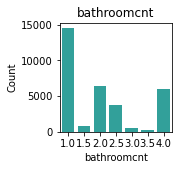

         bathroomcnt  Count  Percent
2.00000      1.00000  14506 44.75000
1.00000      2.00000   6440 19.87000
3.00000      4.00000   6021 18.57000
2.50000      2.50000   3731 11.51000
1.50000      1.50000    812  2.51000
4.00000      3.00000    599  1.85000
3.50000      3.50000    306  0.94000
_________________________________________________________________


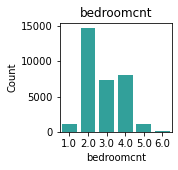

         bedroomcnt  Count  Percent
3.00000     2.00000  14698 45.34000
2.00000     4.00000   8015 24.73000
4.00000     3.00000   7389 22.80000
5.00000     1.00000   1135  3.50000
1.00000     5.00000   1062  3.28000
6.00000     6.00000    116  0.36000
_________________________________________________________________


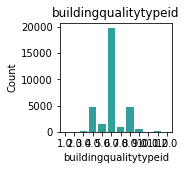

          buildingqualitytypeid  Count  Percent
6.00000                 6.00000  19795 61.07000
8.00000                 4.00000   4809 14.84000
4.00000                 8.00000   4726 14.58000
7.00000                 5.00000   1526  4.71000
5.00000                 7.00000    854  2.63000
9.00000                 9.00000    461  1.42000
11.00000               11.00000    131  0.40000
3.00000                 3.00000     74  0.23000
10.00000                2.00000     24  0.07000
12.00000               12.00000     10  0.03000
2.00000                10.00000      3  0.01000
1.00000                 1.00000      2  0.01000
_________________________________________________________________


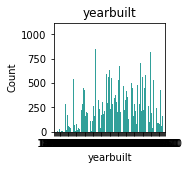

            yearbuilt  Count  Percent
1955.00000 1940.00000   1063  3.28000
1950.00000 1969.00000    927  2.86000
1954.00000 1938.00000    847  2.61000
1953.00000 2000.00000    815  2.51000
1956.00000 1997.00000    745  2.30000
...               ...    ...      ...
1898.00000 1890.00000      2  0.01000
1888.00000 1885.00000      2  0.01000
1887.00000 2016.00000      1  0.00000
2016.00000 1902.00000      1  0.00000
1896.00000 1898.00000      1  0.00000

[125 rows x 3 columns]
_________________________________________________________________


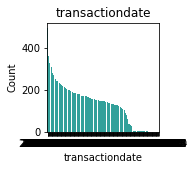

           transactiondate  Count  Percent
2017-06-30      2017-04-18    493  1.52000
2017-05-31      2017-04-28    366  1.13000
2017-04-28      2017-06-30    362  1.12000
2017-05-26      2017-08-18    345  1.06000
2017-07-28      2017-01-10    327  1.01000
...                    ...    ...      ...
2017-08-06      2017-04-02      1  0.00000
2017-01-28      2017-04-08      1  0.00000
2017-01-14      2017-03-25      1  0.00000
2017-04-02      2017-06-24      1  0.00000
2017-09-04      2017-06-10      1  0.00000

[249 rows x 3 columns]
_________________________________________________________________


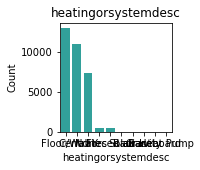

           heatingorsystemdesc  Count  Percent
None                Floor/Wall  13035 40.21000
Central                Central  11013 33.98000
Floor/Wall                None   7371 22.74000
Yes                        Yes    500  1.54000
Forced air          Forced air    440  1.36000
Solar                    Solar     30  0.09000
Radiant                Radiant     18  0.06000
Baseboard              Gravity      4  0.01000
Gravity              Baseboard      3  0.01000
Heat Pump            Heat Pump      1  0.00000
_________________________________________________________________


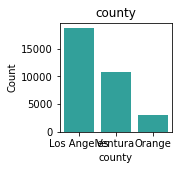

                  county  Count  Percent
Los Angeles  Los Angeles  18684 57.64000
Orange           Ventura  10757 33.19000
Ventura           Orange   2974  9.17000
_________________________________________________________________


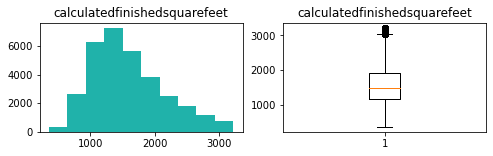

count   32415.00000
mean     1590.43070
std       566.36257
min       360.00000
25%      1171.00000
50%      1488.00000
75%      1922.00000
max      3216.00000
Name: calculatedfinishedsquarefeet, dtype: float64


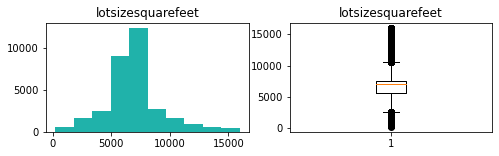

count   32415.00000
mean     6917.47583
std      2440.92366
min       236.00000
25%      5600.00000
50%      7000.00000
75%      7593.00000
max     15970.00000
Name: lotsizesquarefeet, dtype: float64


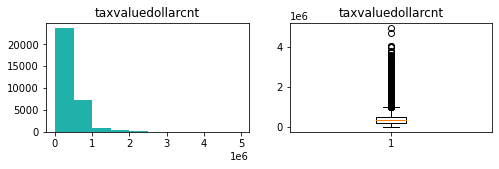

count     32415.00000
mean     406809.38454
std      333161.57919
min        9242.00000
25%      192192.00000
50%      344000.00000
75%      522874.50000
max     4961367.00000
Name: taxvaluedollarcnt, dtype: float64


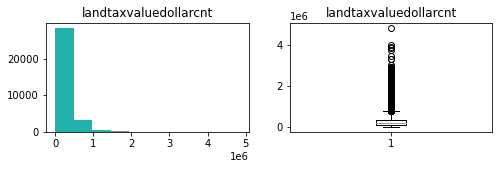

count     32415.00000
mean     259428.41360
std      262132.11312
min        2250.00000
25%       80715.50000
50%      201747.00000
75%      351000.00000
max     4847224.00000
Name: landtaxvaluedollarcnt, dtype: float64


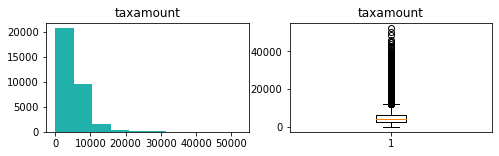

count   32415.00000
mean     4996.13068
std      3856.60314
min        19.92000
25%      2554.65000
50%      4231.12000
75%      6306.97500
max     52419.76000
Name: taxamount, dtype: float64


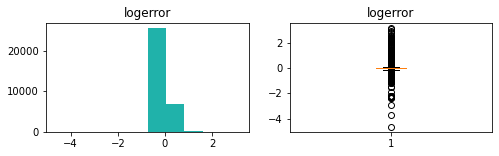

count   32415.00000
mean        0.01507
std         0.16103
min        -4.65542
25%        -0.02386
50%         0.00560
75%         0.03543
max         3.17569
Name: logerror, dtype: float64


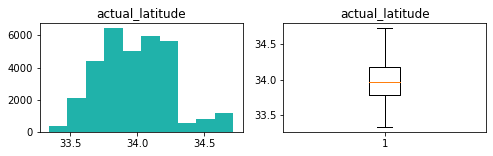

count   32415.00000
mean       33.98162
std         0.27010
min        33.33953
25%        33.78515
50%        33.96450
75%        34.16767
max        34.71828
Name: actual_latitude, dtype: float64


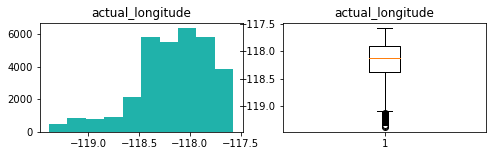

count   32415.00000
mean     -118.17154
std         0.37089
min      -119.38835
25%      -118.38007
50%      -118.12262
75%      -117.89497
max      -117.57242
Name: actual_longitude, dtype: float64


In [30]:
# Explore Univariate
cat_vars = ['bathroomcnt','bedroomcnt','buildingqualitytypeid','yearbuilt',\
            'transactiondate','heatingorsystemdesc','county']
quant_vars = ['calculatedfinishedsquarefeet','lotsizesquarefeet',\
               'taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','logerror',\
                'actual_latitude','actual_longitude']
explore_univariate(train, cat_vars, quant_vars)

**Takeaways**:
- not a lot of normal distributions
- depeding on how the test is set up, may need to use ANNOVA or Kruskal Wallis

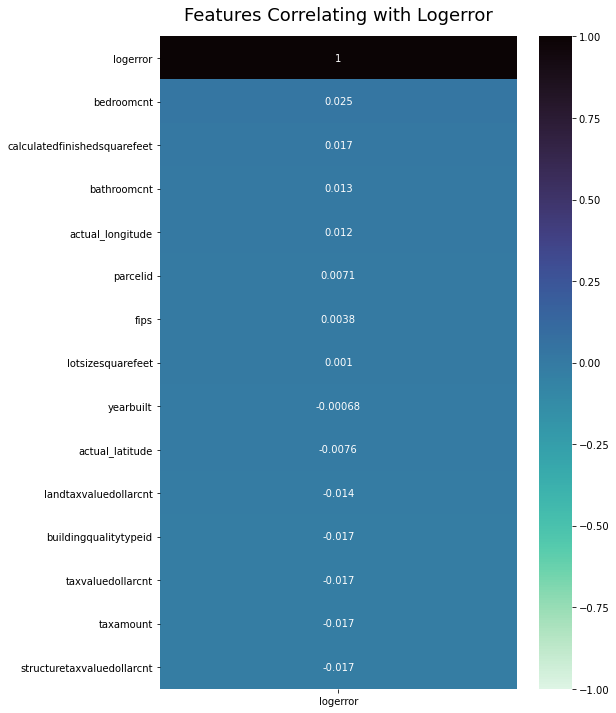

In [31]:
# see what correlates most with logerror with heatmap
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with Logerror', fontdict={'fontsize':18}, pad=16);

In [32]:
# use RFE to find best features for analysis

X = X_train[list(X_train.select_dtypes(exclude=['object']).columns)]
y = y_train

#create model
lm = LinearRegression()
#select hyperparameters
rfe = RFE(estimator=lm, n_features_to_select=5)
#fit model
rfe.fit(X, y)

X.columns[rfe.support_]

Index(['bedroomcnt', 'calculatedfinishedsquarefeet',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt'],
      dtype='object')

**Takeaways**
- bedroomcnt, calculatedfinishedsquarefeet, bathroomcnt are pretty much clustered together, most likely due to colinearity
- same for structuretaxvaluedollarcnt, taxamount, taxvaluedollarcnt . . . based on previous projects, we know size is a big driver of value
- outside of that, building quality type id and longitude
- longitude is interesting since there could be some correlation between location of the home and how far away it is from the beach (east vs west)
- simply put: **size, location, building quality**

#### Taking a closer look

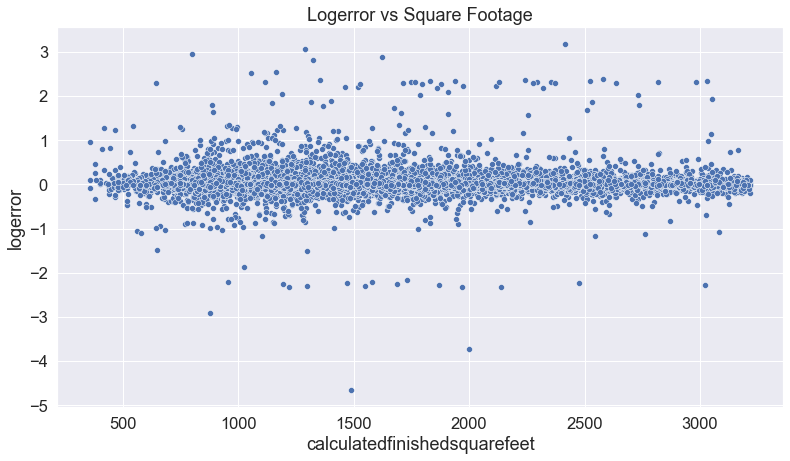

In [33]:
# Logerror and calculatedfinishedsquarefeet
sns.set(font_scale = 1.5)
plt.figure(figsize = (13,7))
sns.scatterplot(data=train, y=train.logerror, x = train.calculatedfinishedsquarefeet)
plt.title('Logerror vs Square Footage')
plt.show()

Nothing really noticable here, some variance as the squarefeet increases, but I'm really working to see that

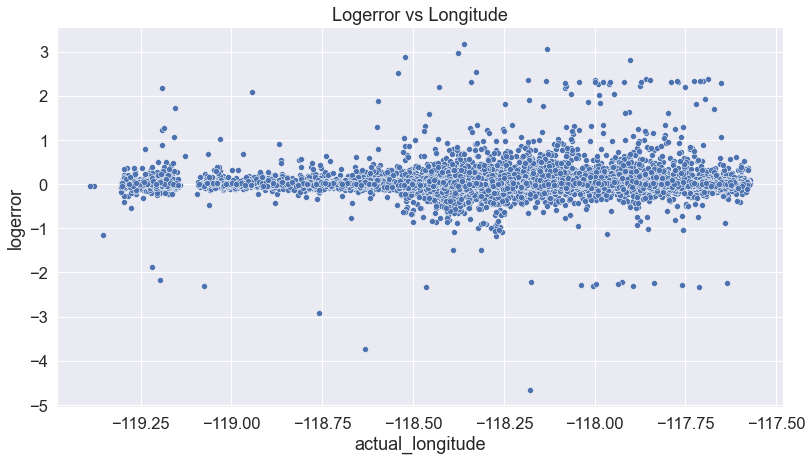

In [34]:
# Logerror and longitude...using "actual" for readability
plt.figure(figsize = (13,7))
sns.scatterplot(data=train, y=train.logerror, x = train.actual_longitude)
plt.title('Logerror vs Longitude')
plt.show()

We do notice some spread in logerror as the homes go further East (the lower the number, the further east)

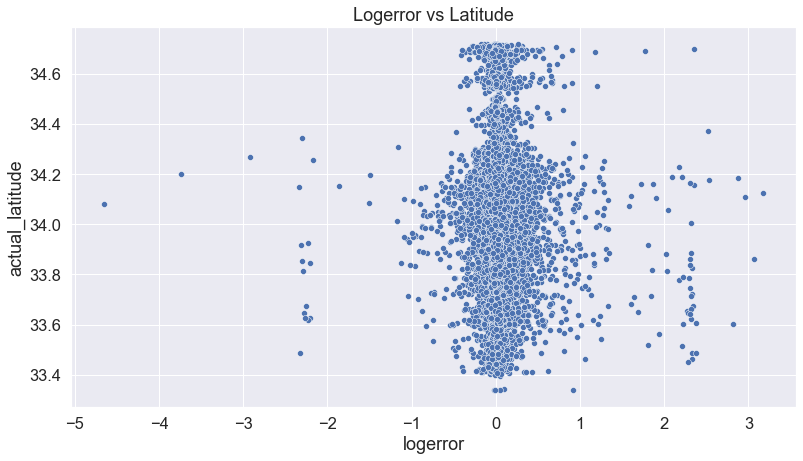

In [35]:
# What about latitude?
plt.figure(figsize = (13,7))
sns.scatterplot(data=train, x=train.logerror, y = train.actual_latitude)
plt.title('Logerror vs Latitude')
plt.show()

- Looks like there's more of a spread the further south you go...not as obvious as longitude though
- Big spread between 34.0 and 34.4
- Will look into location vs Logerror

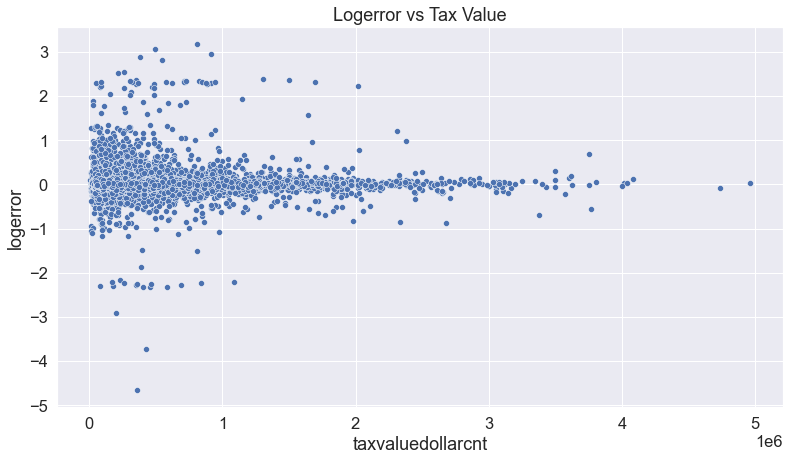

In [36]:
# Logerror and structuretaxvaluedollarcnt
plt.figure(figsize = (13,7))
sns.scatterplot(data=train, y=train.logerror, x = train.taxvaluedollarcnt)
plt.title('Logerror vs Tax Value')
plt.show()

- More error in lower value homes

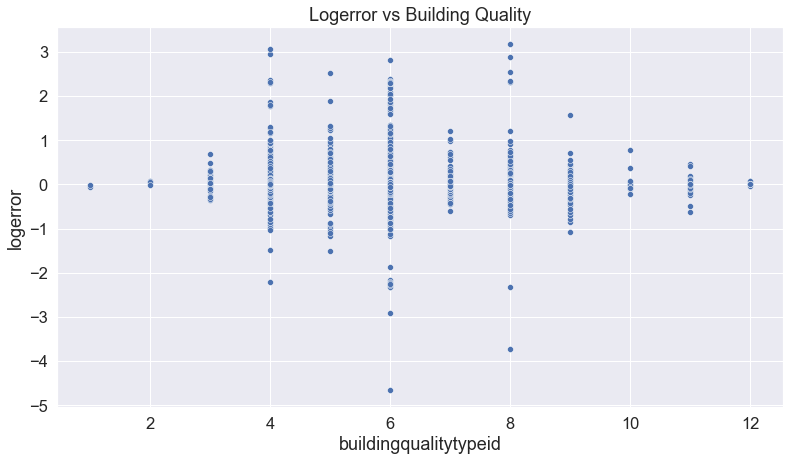

In [37]:
# Logerror and building quality
plt.figure(figsize = (13,7))
sns.scatterplot(data=train, y=train.logerror, x = train.buildingqualitytypeid)
plt.title('Logerror vs Building Quality')
plt.show()

- Looks to be more logerror between the 4-8 range

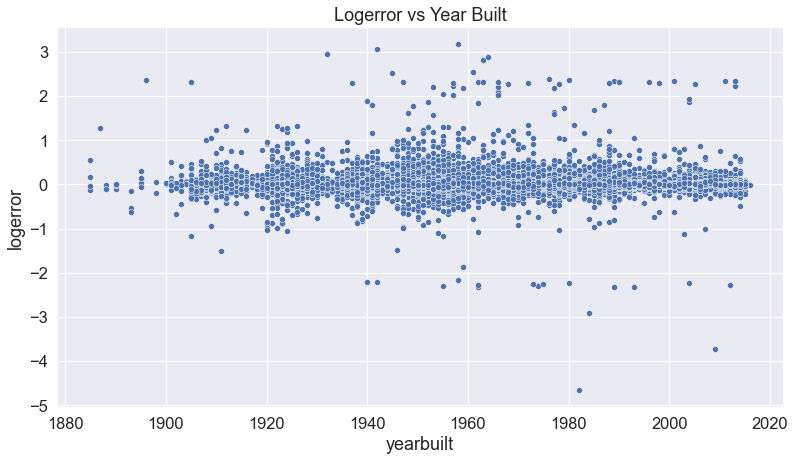

In [38]:
# Logerror vs year the house was built
plt.figure(figsize = (13,7))
sns.scatterplot(data=train, x='yearbuilt', y='logerror')
plt.title('Logerror vs Year Built')
plt.show()

- It appears there is more log error from 1940 to now

### Hypothesis Testing

In [39]:
alpha = .05

### Hypothesis 1: Is logerror significantly different for properties in LA Country vs Orange County vs Ventura County?
- $H_0$: statistically, the means of logerror are not significantly different between the three counties
- $H_a$: statistically, the means of logerror are significantly different between the three counties

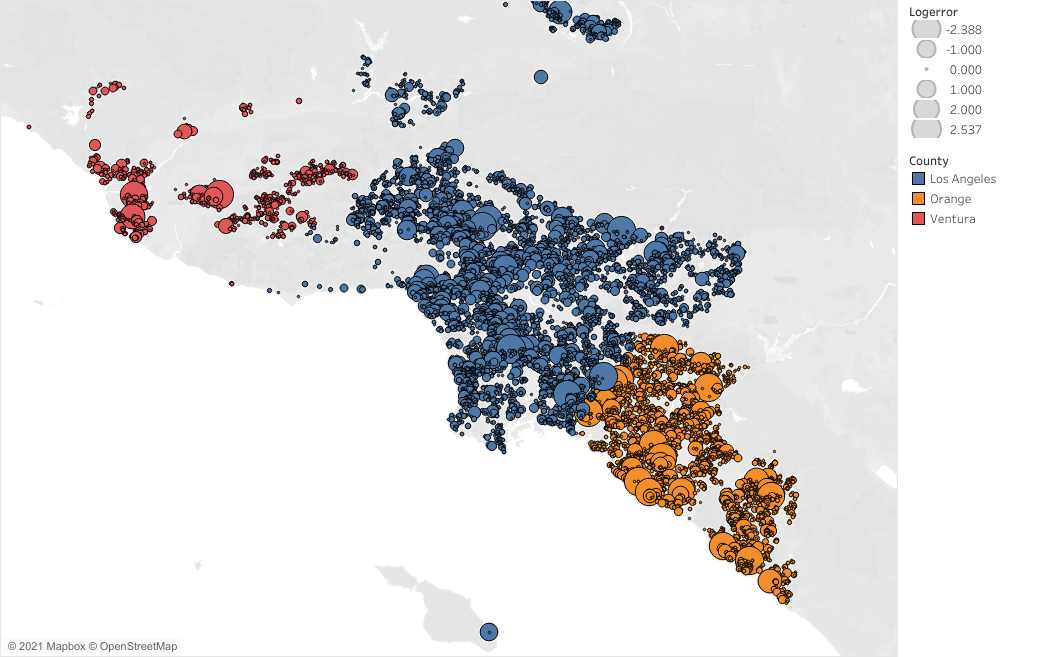

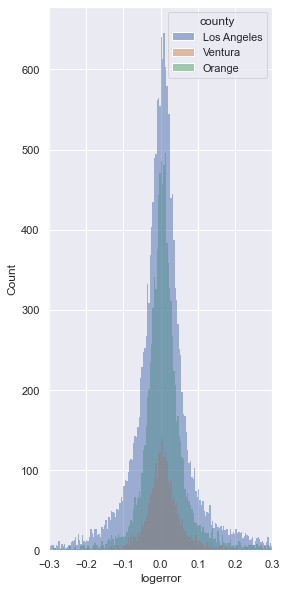

In [40]:
# Creating a histplot to check distribution
sns.set(font_scale=1)
plt.figure(figsize=(4,10))
sns.histplot(data=train, x='logerror', hue='county')
plt.xlim(-.3,.3)
plt.show()

Normally distributed

In [41]:
from scipy.stats import f_oneway
f_oneway(train[train.county=='Los Angeles'].logerror,train[train.county=='Orange'].logerror,\
        train[train.county=='Ventura'].logerror)

F_onewayResult(statistic=2.905044402675477, pvalue=0.0547606144137584)

**Conclusion**:
We **accept** the null hypothesis, the means of logerror for each county are not statistically different from one another

**If we use a barplot, we notice Los Angeles and Ventura counties are very similar and Orange county is different...therefore we can use a one sample T-test to compare each mean to the population**

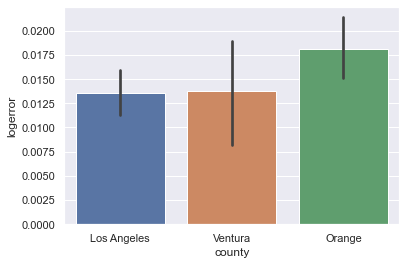

In [42]:
sns.barplot(data=train,y='logerror',x='county')
plt.show()

### Hypothesis 2: Is logerror significantly different for properties in Orange County vs the rest of the population of homes?
- $H_0$: statistically, the means of logerror are not significantly different between Orange County and the rest of the overall average
- $H_a$: statistically, the means of logerror are significantly different between Orange County and the rest of the overall average

In [57]:
t, p = stats.ttest_1samp(train[train.county=='Orange'].logerror,\
                         train[(train.county=='Los Angeles') | (train.county=='Ventura county')].logerror.mean())

print(f't = {t:f}')
print(f'p = {p:f}')

t = 2.790624
p = 0.005270


**Conclusion**:
We **reject** the null hypothesis, the means of logerror for Orange coutny is statistically different from the average logerror of the rest of the population

### Hypothesis 3: Is there a correlation between square feet and logerror?
- $H_0$: There is no correlation between square feet and logerror
- $H_a$: There is a correlation between square feet and logerror

In [ ]:
r, p = stats.pearsonr(train.logerror, train.calculatedfinishedsquarefeet)
print('r-value:',round(r,4),'p-value:',round(p,4))

**Conclusion**:
We **reject** the null hypothesis, there is evidence for correlation between square feet and logerror

### Hypothesis 4: Is there a correlation between logerror and yearbuilt?
- $H_0$: There is no correlation between logerror and yearbuilt
- $H_a$: There is a correlation between logerror and yearbuilt

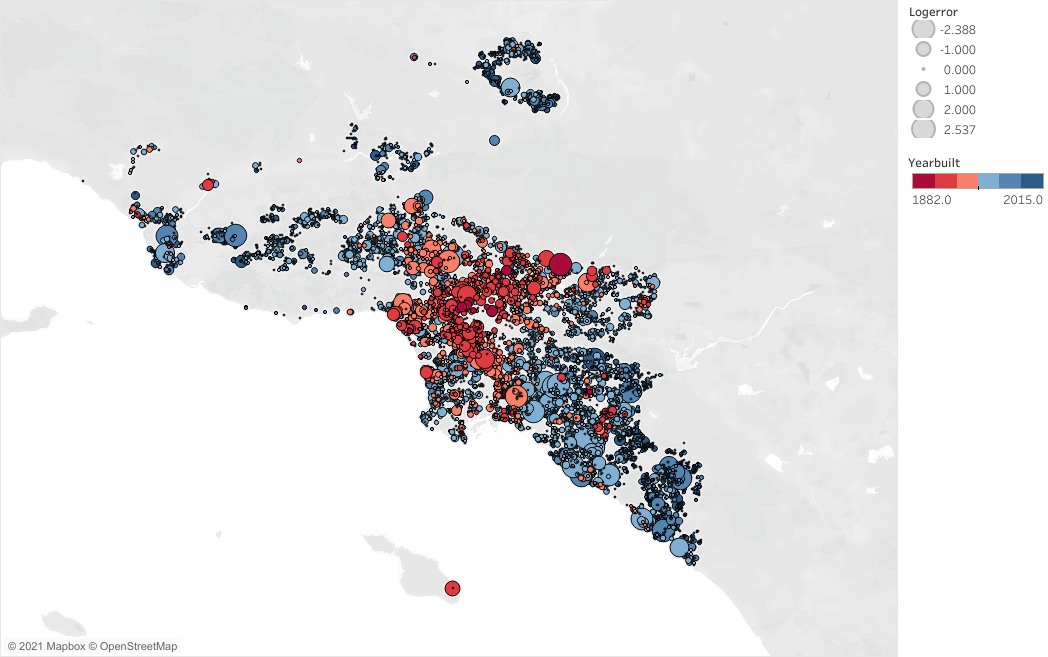

In [ ]:
r, p = stats.pearsonr(train.logerror, train.yearbuilt)
print('r-value:',round(r,4),'p-value:',round(p,4))

**Conclusion**:
We **accept** the null hypothesis, there is no evidence for correlation between yearbuilt and logerror

#### What if we make the year_built into bins?

In [ ]:
train['yearbuilt_binned'] = pd.cut(train.yearbuilt, [1880,1920,1960,2000,2020])

In [ ]:
plt.figure(figsize = (13,7))
sns.scatterplot(data=train, x='yearbuilt', y='logerror',hue='yearbuilt_binned')
plt.show()

Now we can compare the means between the groups of years

In [ ]:
sns.barplot(data=train,y='logerror',x='yearbuilt_binned')
plt.show()

In [ ]:
# Creating a histplot
plt.figure(figsize=(4,10))
sns.histplot(data=train, x='logerror', hue='yearbuilt_binned')
plt.xlim(-.3,.3)
plt.show()

In [ ]:
from scipy.stats import f_oneway
f_oneway(*[x for year, x in train.groupby('yearbuilt_binned').logerror])

**Conclusion**:
We **accept** the null hypothesis, there is no evidence for correlation between yearbuilt bins and logerror

### Hypothesis 5: Is there a correlation between longitude and logerror?
- $H_0$: There is no correlation between logerror and longitude
- $H_a$: There is a correlation between logerror and longitude

In [ ]:
# Logerror and longitude...using "actual" for readability
plt.figure(figsize = (13,7))
sns.scatterplot(data=train, y=train.logerror, x = train.actual_longitude)
plt.show()

In [ ]:
r, p = stats.pearsonr(train.logerror, train.actual_longitude)
print('r-value:',round(r,4),'p-value:',round(p,4))

**Conclusion**:
We **reject** the null hypothesis, there is evidence for correlation between longitude and logerror

### Hypothesis 6: Is there a correlation between buildingqualitytypeid and logerror?
- $H_0$: There is no correlation between logerror and buildingqualitytypeid
- $H_a$: There is a correlation between logerror and buildingqualitytypeid

In [ ]:
plt.figure(figsize = (13,7))
sns.scatterplot(data=train, x='buildingqualitytypeid', y='logerror')
plt.show()

In [ ]:
r, p = stats.pearsonr(train.logerror, train.buildingqualitytypeid)
print('r-value:',round(r,4),'p-value:',round(p,4))

**Conclusion**:
We **reject** the null hypothesis, there is evidence for correlation between building quality and logerror

**Takeaways**
- We rejected the null hypotheses for **square feet, longitude, and building quality**...evidence shows there is a correlation between these variables and logerror

## Clustering

### Cluster 1: longitude and square footage

In [ ]:
# We know longitude is a driver with relation to the beach, what if we mix with the squarefootage?
X = X_train[['actual_longitude', 'calculatedfinishedsquarefeet']]
X.head()

In [ ]:
# Scale the X
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [ ]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
# use scatter_plot function from explore.py
# this will show you different clusters with varying k values
scatter_plots(X_scaled, col_name= 'actual_longitude', col_name_two= 'calculatedfinishedsquarefeet')

In [ ]:
# use create_cluster function from explore.py
X_train, X_scaled, scaler, kmeans, centroids_scaled = create_cluster(X_train, X, 5, col_name= 'longitude_sqft_cluster')

In [ ]:
#plot only k=5
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'actual_longitude', y = 'calculatedfinishedsquarefeet', data = X_train, hue = 'longitude_sqft_cluster',palette='mako' )
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
centroids.plot.scatter(y='calculatedfinishedsquarefeet', x= 'actual_longitude', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of longitude and square feet')
plt.show()

**Takeaways**
- Cluster 0: Far West, smaller homes
- Cluster 1: Far East, larger half of homes
- Cluster 2: Middle, smaller half of homes
- Cluster 3: Far East, smaller half of homes
- Cluster 4: Mid to West, larger half of homes

### Cluster 2: building quality and yearbuilt

In [ ]:
# We know building quality was a driver and we rejected the null that there was no correlation with log error,
# what would that look like combined with when the house was built...
X = X_train[['buildingqualitytypeid', 'yearbuilt']]
X.head()

In [ ]:
# Scale the X
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [ ]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
# use scatter_plot function from explore.py
# this will show you different clusters with varying k values
scatter_plots(X_scaled, col_name= 'buildingqualitytypeid', col_name_two= 'yearbuilt')

In [ ]:
# use create_cluster function from explore.py
X_train, X_scaled, scaler, kmeans, centroids_scaled = create_cluster(X_train, X, 6, col_name= 'buildingquality_year_cluster')

In [ ]:
#plot only k=6
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'buildingqualitytypeid', y = 'yearbuilt', data = X_train, hue = 'buildingquality_year_cluster',palette='mako' )
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
centroids.plot.scatter(y='yearbuilt', x= 'buildingqualitytypeid', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of building quality and year built')
plt.show()

**Takeaways**
- Cluster 0: Middle quality, 1940-1970 range...most of the points are concentrated here
- Cluster 1: Higher quality, newer homes
- Cluster 2: Lower quality, older homes
- Cluster 3: Middle to low quality, newer homes
- Cluster 4: Higher quality, older homes
- Cluster 5: Low-mid quality, older homes

### Cluster 3: taxvalue, bedroomcnt

In [ ]:
# Trying to combine value and bedrooms
X = X_train[['taxvaluedollarcnt','bedroomcnt']]
X.head()

In [ ]:
# Scale the X
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [ ]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
# use scatter_plot function from explore.py
# this will show you different clusters with varying k values
scatter_plots(X_scaled, col_name= 'taxvaluedollarcnt', col_name_two= 'bedroomcnt')

In [ ]:
# use create_cluster function from explore.py
X_train, X_scaled, scaler, kmeans, centroids_scaled = create_cluster(X_train, X, 5, col_name= 'taxvalue_bedroom_cluster')

In [ ]:
#plot only k=5
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'taxvaluedollarcnt', y = 'bedroomcnt', data = X_train, hue = 'taxvalue_bedroom_cluster',palette='mako' )
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
centroids.plot.scatter(y='bedroomcnt', x= 'taxvaluedollarcnt', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of tax value and bed room count')
plt.show()

**Takeaways**
- Cluster 0: 3 bedrooms, lower taxvalue
- Cluster 1: 1-2 bedrooms, lower taxvalue
- Cluster 2: 4-6 bedrooms, lower taxvalue
- Cluster 3: 1-6 bedrooms, higher end taxvalue
- Cluster 4: 1-5 bedrooms, mid range taxvalue

In [ ]:
# Dropping columns for my models
X_train.drop(columns=['parcelid','transactiondate','heatingorsystemdesc','county'], inplace=True)
X_validate.drop(columns=['parcelid','transactiondate','heatingorsystemdesc','county'], inplace=True)
X_test.drop(columns=['parcelid','transactiondate','heatingorsystemdesc','county'], inplace=True)

### Using RFE on Clusters

In [ ]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object. 
rfe = RFE(lm, 16)

# fit the data using RFE
rfe.fit(X_train,y_train)

# get the mask of the columns selected
featuremask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,featuremask].columns.tolist()
rfe_feature

**Takeaways** 
- clusters are not useful
- bathroomcnt, bedroomcnt, buildingquality are the top three

## Stats Test on Clusters

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame({'actual': y_train})
y_validate = pd.DataFrame({'actual': y_validate})
y_test = pd.DataFrame({'actual': y_test})

### Cluster #1 Stats Test - Longitude and Square Feet
- $H_0$: There is no relationship between logerror and cluster #1
- $H_a$: There is a relationship between logerror and cluster #1

In [ ]:
#set alpha
alpha = .05

#r,p = stats.pearsonsr(x,y)
r, p = stats.pearsonr(y_train.actual, X_train.longitude_sqft_cluster)

print('r-value:',round(r,4),'p-value:',round(p,4))

In [ ]:
if p <alpha: 
    print('We fail to reject null hypothesis. There is a relationship between logerror and cluster #1')
else:
    print('We reject our null hypothesis. There is no relationship between logerror and cluster #1')

### Cluster #2 Stats Test - Building Quality and Year built
- $H_0$: There is no relationship between logerror and cluster #2
- $H_a$: There is a relationship between logerror and cluster #2

In [ ]:
#set alpha
alpha = .05

#r,p = stats.pearsonsr(x,y)
r, p = stats.pearsonr(y_train.actual, X_train.buildingquality_year_cluster)

print('r-value:',round(r,4),'p-value:',round(p,4))

In [ ]:
if p <alpha: 
    print('We fail to reject null hypothesis. There is a relationship between logerror and cluster #2')
else:
    print('We reject our null hypothesis. There is no relationship between logerror and cluster #2')

### Cluster #3 Stats Test - Tax Value and Bedroom Count
- $H_0$: There is no relationship between logerror and cluster #3
- $H_a$: There is a relationship between logerror and cluster #3

In [ ]:
#set alpha
alpha = .05

#r,p = stats.pearsonsr(x,y)
r, p = stats.pearsonr(y_train.actual, X_train.taxvalue_bedroom_cluster)

print('r-value:',round(r,4),'p-value:',round(p,4))

In [ ]:
if p <alpha: 
    print('We fail to reject null hypothesis. There is a relationship between logerror and cluster #3')
else:
    print('We reject our null hypothesis. There is no relationship between logerror and cluster #3')

## Modeling

#### Creating a baseline

In [ ]:
baseline= y_train['actual'].mean()

In [ ]:
#create column called baseline to compare
y_train['baseline'] = baseline

In [ ]:
#calculate RMSE for baseline model
rmse_baseline_train= math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

In [ ]:
# predict validate
y_validate['baseline'] = baseline

# evaluate: rmse
rmse_baseline_validate = math.sqrt(mean_squared_error(y_validate.actual, y_validate.baseline))

In [ ]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [ ]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_validate.actual,
                           y_validate.baseline,
                           'mean_baseline',
                          metric_df)
metric_df

#### Choose Features

In [ ]:
# Chosen from RFE while trying not to overfit (ex.bedroom and bathroom count)
features = ['bedroomcnt','buildingqualitytypeid','actual_longitude']

## Model #1: LinearRegression (OLS)¶


In [ ]:
#ordinary least squares
#create the model 
model1 = LinearRegression(normalize=True)

#fit the model
model1.fit(X_train_scaled[features], y_train.actual)

In [ ]:
# predict train
y_train['logerror_pred_lm'] = model1.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = model1.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train,5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,5))

In [ ]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.actual, y_validate.logerror_pred_lm)}, ignore_index=True)
metric_df

## Model #2: LassoLars

In [ ]:
# create the model object
model2 = LassoLars(alpha= 1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
model2.fit(X_train_scaled[features], y_train.actual)

# predict train
y_train['logerror_pred_lars'] = model2.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = model2.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train,5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,5))

In [ ]:
metric_df = make_metric_df(y_validate.actual,
               y_validate.logerror_pred_lars,
               'lasso_alpha_1',
               metric_df)
metric_df

## Model #3: Tweedie Regressor

In [ ]:
#create model object
glm = TweedieRegressor(power = 0,alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled[features],y_train.actual)

#predict train
y_train['logerror_pred_glm'] = glm.predict(X_train_scaled[features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_glm)**(1/2)

#predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled[features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", round(rmse_train,5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,5))

In [ ]:
metric_df = make_metric_df(y_validate.actual,
               y_validate.logerror_pred_glm,
               'tweedie_regressor',
               metric_df)
metric_df

## Model #4: Polynomial Features

In [ ]:
#make the polynomial features to get a new set of features
model4 = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = model4.fit_transform(X_train_scaled[features])

# transform X_validate_scaled 
X_validate_degree2 = model4.transform(X_validate_scaled[features])

In [ ]:
#create the model
lm2 = LinearRegression(normalize=True)

#fit the mode
lm2.fit(X_train_degree2, y_train.actual)

#use the model
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", round(rmse_train,5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,5))

In [ ]:
metric_df = make_metric_df(y_validate.actual,
               y_validate.logerror_pred_lm2,
               'polynomial regression',
               metric_df)
metric_df

In [ ]:
# Using OLS for test since it did better on Validate

# predict train
y_train['logerror_pred_lm'] = model1.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = model1.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm)**(1/2)

# predict test
y_test['logerror_pred_lm'] = model1.predict(X_test_scaled[features])

# evaluate: rmse
rmse_test = mean_squared_error(y_test.actual, y_test.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train,5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,5),
      "\nTest/Out-of-Sample: ", round(rmse_test,5))
                                            

### Conclusion:
- While my model was able to beat my baseline on Train and Validate, it was not able to beat it on test data
- Could be because of overfitting due to my hyperparameters

### With more time:
- I would like to dig into clustering more and spend more time with different combinations
- While my model ultimately did not beat the baseline on test, I do think these features should be looked into more and with more time, could be engineered better to predict logerror of unseen data